<a href="https://colab.research.google.com/github/itchyfeet-patient/Beautiful-Exploration/blob/master/Exploration_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **10-10. 프로젝트 : 단어 Level로 번역기 업그레이드하기 🆎 🔊**
프로젝트를 진행하기 전에 주요 라이브러리 버전을 확인해 보죠.

In [ ]:
import re

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, GRU, Dense

print(tf.__version__)

2.8.2


실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다. 하지만 실제 번역기의 경우에는 글자 단위가 아니라 **단어 단위(Word-level)**에서 구현되는 것이 좀 더 보편적입니다.  

동일한 데이터셋을 사용하면서 글자 단위와는 **다른 전처리**와 **임베딩 층**(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 **단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다.** 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.  

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

In [ ]:
file_path = '/content/drive/MyDrive/dataset/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


,eng,fra,cc
91573,You've made a huge mistake.,Tu as fait une grosse erreur.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
131374,What were you doing at that time?,Que faisiez-vous à cette époque ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
33765,You're pretty good.,Vous êtes plutôt bonne.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
160522,I've already finished reading this book.,J'ai déjà fini de lire ce livre.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
51441,Summer has just begun.,L'été a juste commencé.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [ ]:
lines = lines[['eng', 'fra']][:33000] # 3만3천개 샘플 사용
lines.sample(5)

,eng,fra
9032,We can't fail.,Nous ne pouvons pas échouer.
4886,I felt great.,Je me suis très bien senti.
24345,I wasn't punished.,Je n'étais pas punie.
18782,I must leave now.,Je dois partir maintenant.
5981,This is sick.,C'est dingue.


## **Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)**  
글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.  

**1. 구두점(Punctuation)을 단어와 분리해주세요.**   
일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization)이라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요. 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.  

예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면  

['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로  

좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.  

!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다.  

이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!  

분리 전 : he is a Good boy!   

분리 후 : he is a Good boy !  

**2. 소문자로 바꿔주세요.**  
기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

변환 전 : he is a Good boy !  

변환 후 : he is a good boy !  

**3. 띄어쓰기 단위로 토큰화를 수행하세요.**   
띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.  

토큰화 전 : 'he is a good boy !'  

토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']  

**4. 프랑스어 악센트 삭제?**  
'déjà diné' -> deja dine

In [ ]:
# pip install unidecode

In [ ]:
import unidecode
accented_string = 'Málaga!'
# accented_string is of type 'unicode'

unaccented_string = unidecode.unidecode(accented_string)
# unaccented_string contains 'Malaga'and is of type 'str'

In [ ]:
unaccented_string

'Malaga!'

In [ ]:
def preprocess_sentence(sentence):

    sentence = unidecode.unidecode(sentence)
    # 1 구두점들 중 하나에 해당되면 양쪽에 공백넣어서 " 해당 그것 " 이렇게 바꿔라)
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    # 2. 소문자로 바꿔주세요
    sentence = sentence.lower().strip()
    # 정규표현식 모듈 re  .sub 메소드 - 매치된 부분을 치환
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 공백 " "이 한번이상 반복되면(+) , " "로 바까라
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    # 소문자 a~z 거나 A~Z 거나 ? . , ! 거꾸로물음표 를 제외(^)한게 한번이상 반복(+)되면 " " 공백으로 바꿔라 
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = sentence.strip()
    # 다시 양쪽공백없애라!!
    
    return sentence

def tokenize(sentence):
    tokenizer = sentence.split()
    
    return tokenizer


print(preprocess_sentence("Courez!"))
print(tokenize(preprocess_sentence("Courez!")))

courez !
['courez', '!']


전처리 수행

In [ ]:
encoder_input = []

for sentence in lines.eng :
    # 길이가 0인 문장은 건너뛰기
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence) #정제
    preprocessed_sentence = tokenize(preprocessed_sentence)
    encoder_input.append(preprocessed_sentence) # 담기
        
# 정제된 결과를 10개만 확인해보죠
encoder_input[:10]

[['go', '.'],
 ['go', '.'],
 ['go', '.'],
 ['hi', '.'],
 ['hi', '.'],
 ['run', '!'],
 ['run', '!'],
 ['run', '!'],
 ['run', '!'],
 ['run', '!']]

In [ ]:
decoder_input = []

for sentence in lines.fra :
    # 길이가 0인 문장은 건너뛰기
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    
    preprocessed_sentence = preprocess_sentence(sentence) #정제
    preprocessed_sentence = '<sos> ' + preprocessed_sentence
    preprocessed_sentence = tokenize(preprocessed_sentence)
    
    decoder_input.append(preprocessed_sentence) # 담기
    
        
# 정제된 결과를 10개만 확인해보죠
decoder_input[:10]

[['<sos>', 'va', '!'],
 ['<sos>', 'marche', '.'],
 ['<sos>', 'bouge', '!'],
 ['<sos>', 'salut', '!'],
 ['<sos>', 'salut', '.'],
 ['<sos>', 'cours', '!'],
 ['<sos>', 'courez', '!'],
 ['<sos>', 'prenez', 'vos', 'jambes', 'a', 'vos', 'cous', '!'],
 ['<sos>', 'file', '!'],
 ['<sos>', 'filez', '!']]

In [ ]:
decoder_label = []

for sentence in lines.fra :
    # 길이가 0인 문장은 건너뛰기
    if len(sentence) == 0: continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence) #정제
    preprocessed_sentence = preprocessed_sentence + ' <eos>'
    preprocessed_sentence = tokenize(preprocessed_sentence)
    decoder_label.append(preprocessed_sentence) # 담기
        
# 정제된 결과를 10개만 확인해보죠
decoder_label[:10]

[['va', '!', '<eos>'],
 ['marche', '.', '<eos>'],
 ['bouge', '!', '<eos>'],
 ['salut', '!', '<eos>'],
 ['salut', '.', '<eos>'],
 ['cours', '!', '<eos>'],
 ['courez', '!', '<eos>'],
 ['prenez', 'vos', 'jambes', 'a', 'vos', 'cous', '!', '<eos>'],
 ['file', '!', '<eos>'],
 ['filez', '!', '<eos>']]

## **Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.**
글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 가 필요합니다.

예를 들어 번역 문장이 Courez!이었다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : `['courez', '!']`

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : `['', 'courez', '!']`

레이블 시퀀스 : `['courez', '!', ']`

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!

Step 1을 수행하는 중간에 수행해도 상관없습니다.



In [ ]:
print('인코더의 입력 :',encoder_input[:10])
print('디코더의 입력 :',decoder_input[:10])
print('디코더의 레이블 :',decoder_label[:10])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.'], ['<sos>', 'cours', '!'], ['<sos>', 'courez', '!'], ['<sos>', 'prenez', 'vos', 'jambes', 'a', 'vos', 'cous', '!'], ['<sos>', 'file', '!'], ['<sos>', 'filez', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>'], ['cours', '!', '<eos>'], ['courez', '!', '<eos>'], ['prenez', 'vos', 'jambes', 'a', 'vos', 'cous', '!', '<eos>'], ['file', '!', '<eos>'], ['filez', '!', '<eos>']]


## **Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.**
딥 러닝 모델은 각 단어를 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요. 케라스 토크나이저의 사용법은

아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리 에 설명되어져 있습니다.  

[위키독스](https://wikidocs.net/31766)  
위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고,

tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.

In [ ]:
from itertools import islice
tokenizer_eng = Tokenizer(filters=" ")
tokenizer_eng.fit_on_texts(encoder_input)
print(dict(islice(tokenizer_eng.word_index.items(), 5)))
print(dict(islice(tokenizer_eng.word_counts.items(), 5)))
print(tokenizer_eng.texts_to_sequences(encoder_input)[:5])

encoder_input = tokenizer_eng.texts_to_sequences(encoder_input)
encoder_input = pad_sequences(encoder_input, padding='post')# 패딩



{'.': 1, 'i': 2, 'you': 3, '?': 4, 'tom': 5}
{'go': 802, '.': 27844, 'hi': 14, 'run': 70, '!': 1030}
[[29, 1], [29, 1], [29, 1], [765, 1], [765, 1]]


In [ ]:
tokenizer_fra = Tokenizer(filters=" ")
tokenizer_fra.fit_on_texts(decoder_input)
tokenizer_fra.fit_on_texts(decoder_label)
print(dict(islice(tokenizer_fra.word_index.items(), 5)))
print(dict(islice(tokenizer_fra.word_counts.items(), 5)))
print(tokenizer_fra.texts_to_sequences(decoder_input)[:5])

decoder_input = tokenizer_fra.texts_to_sequences(decoder_input)
decoder_input = pad_sequences(decoder_input, padding='post')

{'.': 1, '<sos>': 2, '<eos>': 3, 'je': 4, 'est': 5}
{'<sos>': 33000, 'va': 582, '!': 6094, 'marche': 134, '.': 51664}
[[2, 73, 9], [2, 208, 1], [2, 626, 9], [2, 713, 9], [2, 713, 1]]


In [ ]:

print(tokenizer_fra.texts_to_sequences(decoder_label)[:10])
decoder_label = tokenizer_fra.texts_to_sequences(decoder_label)
decoder_label = pad_sequences(decoder_label, padding='post')

[[73, 9, 3], [208, 1, 3], [626, 9, 3], [713, 9, 3], [713, 1, 3], [650, 9, 3], [1802, 9, 3], [176, 256, 984, 8, 256, 2636, 9, 3], [846, 9, 3], [2135, 9, 3]]


In [ ]:
print(decoder_input[0])
print(decoder_label[0])


[ 2 73  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
[73  9  3  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
max_eng_seq_len = max([len(line) for line in encoder_input])
max_fra_seq_len = max([len(line) for line in decoder_input])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


In [ ]:
print('인코더 입력 크기(shape) :',np.shape(encoder_input))
print('디코더 입력 크기(shape) :',np.shape(decoder_input))
print('디코더 레이블 크기(shape) :',np.shape(decoder_label))

인코더 입력 크기(shape) : (33000, 8)
디코더 입력 크기(shape) : (33000, 16)
디코더 레이블 크기(shape) : (33000, 16)


In [ ]:
print(encoder_input[0])
print(decoder_input[0])
print(decoder_label[0])

[29  1  0  0  0  0  0  0]
[ 2 73  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
[73  9  3  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
eng_vocab_size = len(tokenizer_eng.word_index) + 1
fra_vocab_size = len(tokenizer_fra.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 8154


In [ ]:
src_to_index = tokenizer_eng.word_index
index_to_src = tokenizer_eng.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 3580 20639  5641 ...  6355 27569 31452]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_label = decoder_label[indices]

In [ ]:
encoder_input[30997]    

array([  14,  193, 3730,    1,    0,    0,    0,    0], dtype=int32)

In [ ]:
decoder_input[30997]

array([   2,   22,  108, 6230,    1,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
decoder_label[30997]

array([  22,  108, 6230,    1,    3,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

훈련 데이터 30,000개, 테스트 데이터 3,000개로 분리

In [ ]:
test_data = 3000
print('테스트 데이터 개수 :',test_data)

테스트 데이터 개수 : 3000


In [ ]:
encoder_input_train = encoder_input[:-test_data]
decoder_input_train = decoder_input[:-test_data]
decoder_label_train = decoder_label[:-test_data]

encoder_input_test = encoder_input[-test_data:]
decoder_input_test = decoder_input[-test_data:]
decoder_label_test = decoder_label[-test_data:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_label_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_label_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 16)
훈련 target 레이블의 크기 : (30000, 16)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 16)
테스트 target 레이블의 크기 : (3000, 16)


## **Step 4. 임베딩 층(Embedding layer) 사용하기**
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.  

임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의  

1. 케라스 임베딩 층(Keras Embedding layer) 를 참고하세요.  

[위키독스](https://wikidocs.net/33793)  

주의할 점은 **인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용**해야 하지만,

**디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일**해야 합니다!



In [ ]:
# 인코더
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Masking


embedding_dim = 64
hidden_units = 64

# 입력 텐서 생성
encoder_inputs = Input(shape=(None,))
# Embedding layer 생성
enc_emb =  Embedding(eng_vocab_size, embedding_dim, input_length=max_eng_seq_len)(encoder_inputs)
# 패딩 0은 연산에서 제외
enc_masking = Masking(mask_value=0.0)(enc_emb)
# hidden size가 256인 인코더의 LSTM 셀 생성, 상태값 리턴을 위해 return_state=true
encoder_lstm = LSTM(hidden_units, return_state=True)
# 디코더로 전달할 hidden state, cell state를 리턴, encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장
encoder_states = [state_h, state_c]

In [ ]:
# 디코더
from tensorflow.keras.models import Model

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     298944      ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     521856      ['input_6[0][0]']                
                                                                                            

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_label_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_label_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 22s 41ms/step - loss: 3.3701 - acc: 0.6118 - val_loss: 2.0318 - val_acc: 0.6163
Epoch 2/50
235/235 [==============================] - 7s 30ms/step - loss: 1.8733 - acc: 0.6647 - val_loss: 1.7679 - val_acc: 0.7379
Epoch 3/50
235/235 [==============================] - 7s 30ms/step - loss: 1.6784 - acc: 0.7423 - val_loss: 1.6149 - val_acc: 0.7480
Epoch 4/50
235/235 [==============================] - 7s 30ms/step - loss: 1.5397 - acc: 0.7565 - val_loss: 1.4988 - val_acc: 0.7586
Epoch 5/50
235/235 [==============================] - 7s 30ms/step - loss: 1.4334 - acc: 0.7649 - val_loss: 1.4067 - val_acc: 0.7714
Epoch 6/50
235/235 [==============================] - 7s 29ms/step - loss: 1.3381 - acc: 0.7820 - val_loss: 1.3203 - val_acc: 0.7885
Epoch 7/50
235/235 [==============================] - 7s 30ms/step - loss: 1.2556 - acc: 0.7957 - val_loss: 1.2526 - val_acc: 0.7993
Epoch 8/50
235/235 [==============================] - 7s 31ms/step -

## **Step 5. 모델 구현하기**
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요!

In [ ]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

## **Step 6. 모델 평가하기**
단어 단위 번역기에 대해서 훈련 데이터의 샘플과 테스트 데이터의 샘플에 대해서 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)


입력문장 : why are you upset ? 
정답문장 : pourquoi es tu enerve ? 
번역문장 : pourquoi etes vous seuls ? 
--------------------------------------------------
입력문장 : you need to go . 
정답문장 : il faut que tu t en ailles . 
번역문장 : tu dois partir . 
--------------------------------------------------
입력문장 : take control . 
정답문장 : prenez les commandes . 
번역문장 : prenez le controle . 
--------------------------------------------------
입력문장 : is anyone here yet ? 
정답문장 : quiconque est il deja la ? 
번역문장 : a la qui est il deja ? 
--------------------------------------------------
입력문장 : tom ordered this . 
정답문장 : c est tom qui l a commande . 
번역문장 : tom a commande ca . 
--------------------------------------------------


| input | fit | output | output translate |
|:---:|---|---|:---:|
| why are you upset ? | pourquoi es tu enerve ? | pourquoi etes vous seuls ? | 왜 혼자야? |
| you need to go . | il faut que tu t en ailles . | tu dois partir . | 당신은 떠나야합니다. |
| take control . | prenez les commandes . | prenez le controle . | 통제하십시오. |
| is anyone here yet ? | quiconque est il deja la ? | a la qui est il deja ? | 그는 이미 누구입니까? |
| tom ordered this . | c est tom qui l a commande . | tom a commande ca . | 톰은 이것을 주문했다. |

* 3/5 정도, 60% 정도 맞았다. 

In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : i am out of time . 
정답문장 : je suis a court de temps . 
번역문장 : je suis la mort de la maison . 
--------------------------------------------------
입력문장 : close the book . 
정답문장 : ferme le livre . 
번역문장 : ferme le bus . 
--------------------------------------------------
입력문장 : school is over . 
정답문장 : l ecole est terminee . 
번역문장 : l ecole est finie . 
--------------------------------------------------
입력문장 : what did tom steal ? 
정답문장 : qu est ce que tom a vole ? 
번역문장 : qu a tom a t il aide ? 
--------------------------------------------------
입력문장 : i have time . 
정답문장 : je dispose de temps . 
번역문장 : je l ai mal a la maison . 
--------------------------------------------------


| input | fit | output | output translate |
|:---:|---|---|:---:|
| i am out of time .  | je suis a court de temps . | je suis la mort de la maison . | 나는 집의 죽음이다. |
| close the book . | ferme le livre . | ferme le bus . | 버스를 닫습니다. |
| school is over . | l ecole est terminee . | l ecole est finie . | 학교가 끝났습니다. |
| what did tom steal ? | qu est ce que tom a vole ? | qu a tom a t il aide ? | 톰은 무엇을 도왔나요? |
| i have time . | je dispose de temps . | je l ai mal a la maison . | 집에 안좋습니다. |

* 1/5 만 맞았다. 20% ..

### 🎯 **평가 루브릭**
| **평가문항** | **상세기준** | **학습결과** |
|:---:|---|:---:|
| 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. | 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다. | O |
| 2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다. | seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다. | O |
| 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. | 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다. | O |

## ✍ **회고**


* 처음에 are you guys free ? 를 넣었는데

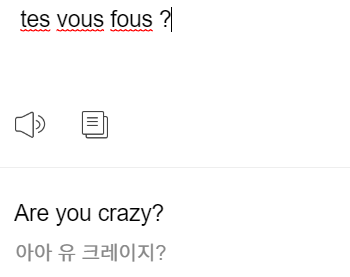

가 나왔다. 싸우자는건가?

---

* 밑의 결과가 나와서 french 악센트가 좀 문제를 일으킬 수도 있다고 생각해서 unidecode 를 사용해서 변환해줬다.

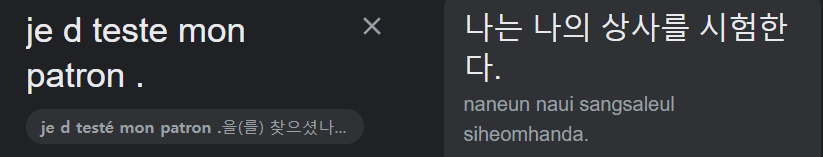

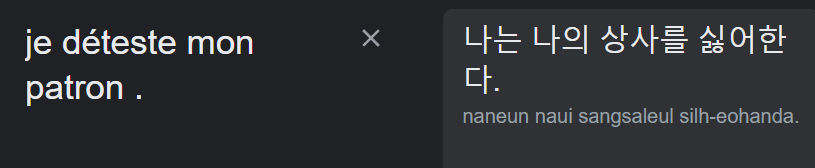

---

* Seq2seq 모델의 단점인 어순 판단의 어려움 때문일까?  
'Is anyone here yet?' 의 번역 결과로 나온 'a la qui est il deja ?' (à la qui est il déjà ?) 는 who is he again? 이라는 뜻인데  
앞에 붙은 'a la' 는 없어도 되는 단어들이다.  
qui : who  
est : is  
il : he  
deja : already  
게다가 a la는 at the 의 의미인 것 같다. 이것저것 찾아봐도 a la가 문장 앞에 나오는 경우는 많지 않아보인다.  
어순을 잘 못 맞춰서 번역하는 경우가 있는 것 같다.  


* nlp는 고려해줘야 하는 사항이 많아서 까다롭다. 그러나 오늘 찾아보니 문자에 꼭 국한된 task들만 있는 것이 아니고 '음성 노이즈 제거~' 같은 task들에도 nlp가 쓰여서 관심이 갔다. 그리고 일반적으로 딥러닝 하면 배우는 모델 구조가 아닌 구조가 있어서 굉장히 낯설지만.. 지금 나한테 안 낯선 게 어딨을까나 덜 낯설거나 더 낯설거나의 차이겠지? 그치만 ex10.. 이해 안되는 부분이 좀 많았다 ... **Au revoir**....

* 중복되는 문장들이 많아서 데이터를 33000개 뽑을 때 인덱싱으로 뽑기보다는 좀 섞어서 뽑았으면 더 길이가 긴 문장을 얻을 수 있었을 텐데.. 그리고 더 다양한 단어를 학습시킬수 있었을텐데 하는 아쉬움이 남는다.

## **참고문헌**


[프랑스어 악센트 제거](http://daplus.net/python-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%9C%A0%EB%8B%88-%EC%BD%94%EB%93%9C-%EB%AC%B8%EC%9E%90%EC%97%B4%EC%97%90%EC%84%9C-%EC%95%85%EC%84%BC%ED%8A%B8%EB%A5%BC-%EC%A0%9C%EA%B1%B0%ED%95%98%EB%8A%94/)  
[전체적인 모델 설계와 전처리 과정 참고](https://wikidocs.net/86900)